In [9]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [7]:
input_dir = 'minimized_dump'
input_file = 'Fe_edge_dislocation_0_minimized'

dislo_dump_path = os.path.join(input_dir, input_file)

In [8]:
def extract_box_data(input_path):
    box_bounds = {}
    with open(input_path, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if "ITEM: BOX BOUNDS" in line:
                x_bounds = list(map(float, lines[i+1].split()))
                y_bounds = list(map(float, lines[i+2].split()))
                z_bounds = list(map(float, lines[i+3].split()))
                box_bounds = {
                    'xlo': x_bounds[0], 'xhi': x_bounds[1],
                    'ylo': y_bounds[0], 'yhi': y_bounds[1],
                    'zlo': z_bounds[0], 'zhi': z_bounds[1],
                }
                break
    return box_bounds

def extract_atom_data(input_path):
    with open(input_path, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if "ITEM: ATOMS" in line:
                headers = line.strip().split()[2:]  # e.g. ['id', 'x', 'y', 'z', 'c_peratom']
                data_start = i + 1
                break
    # Read atom data
    data_lines = lines[data_start:]
    data = [list(map(float, l.strip().split())) for l in data_lines]
    df = pd.DataFrame(data, columns=headers)
    return df

box = extract_box_data(dislo_dump_path)
atom_df = extract_atom_data(dislo_dump_path)

print("Box Dimensions:", box)
print("First few atoms:\n", atom_df.head())

Box Dimensions: {'xlo': 0.0, 'xhi': 202.76507103393442, 'ylo': 0.0, 'yhi': 201.8987649155792, 'zlo': 0.0, 'zhi': 209.81935129151273}
First few atoms:
         id        x         y         z  c_peratom
0  14951.0  66.9157   6.83993  1.007570   -2.88039
1  13861.0  56.9660  10.86650  0.999288   -2.87641
2  14129.0  57.8261  10.82520  3.384790   -3.08314
3  14131.0  59.4902  10.79680  1.190400   -3.47144
4  14401.0  60.3501  10.75500  3.563530   -3.65225


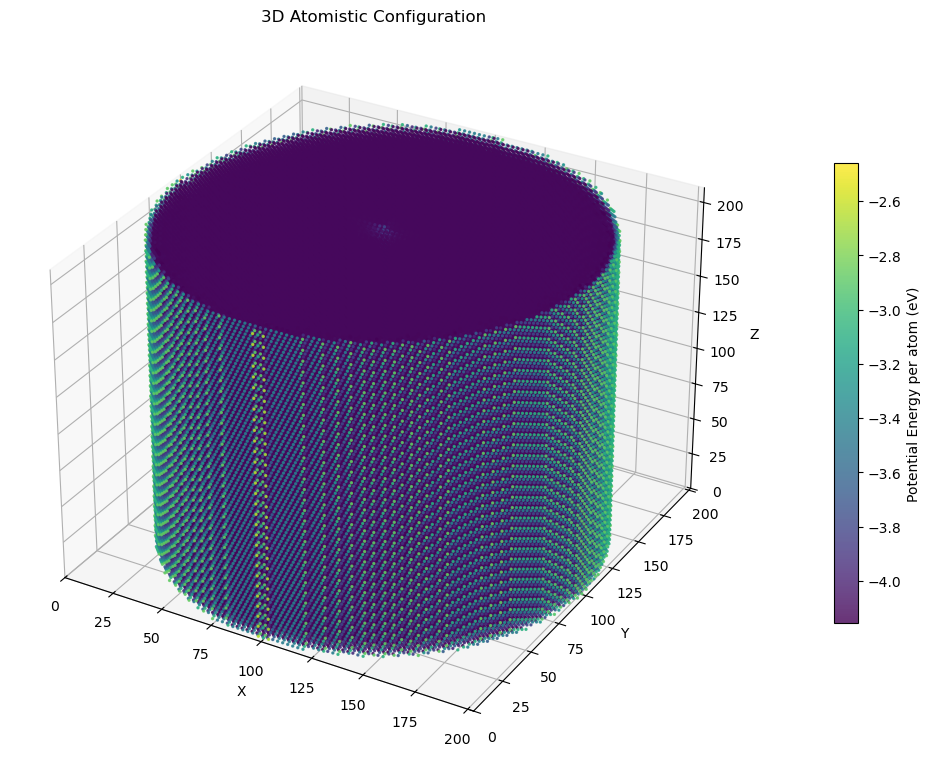

In [12]:
def plot_atomistic_data_3d(atom_df, box, cmap='viridis', alpha=0.8, s=2):
    """
    Plots a 3D scatter plot of atomistic data color-coded by c_peratom.

    Parameters:
        atom_df (pd.DataFrame): DataFrame containing 'x', 'y', 'z', and 'c_peratom' columns.
        box (dict): Dictionary with keys 'xlo', 'xhi', 'ylo', 'yhi', 'zlo', 'zhi' for axis limits.
        cmap (str): Colormap for coloring atoms by c_peratom.
        alpha (float): Transparency of points.
        s (int): Size of points.
    """
    required_cols = ['x', 'y', 'z', 'c_peratom']
    if not all(col in atom_df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    required_keys = ['xlo', 'xhi', 'ylo', 'yhi', 'zlo', 'zhi']
    if not all(k in box for k in required_keys):
        raise ValueError(f"Box must contain keys: {required_keys}")

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    p = ax.scatter(atom_df['x'], atom_df['y'], atom_df['z'], 
                   c=atom_df['c_peratom'], cmap=cmap, alpha=alpha, s=s)

    ax.set_xlim(box['xlo'], box['xhi'])
    ax.set_ylim(box['ylo'], box['yhi'])
    ax.set_zlim(box['zlo'], box['zhi'])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    cbar = fig.colorbar(p, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label('Potential Energy per atom (eV)')

    plt.title('3D Atomistic Data')
    plt.tight_layout()
    plt.show()

plot_atomistic_data_3d(atom_df, box)

In [28]:
def filter_atoms(atom_df, box, radius, c_thresh=-4.0):
    
    # Calculate box center
    x_center = (box['xlo'] + box['xhi']) / 2
    y_center = (box['ylo'] + box['yhi']) / 2

    # Calculate XY distance from center
    dx = atom_df['x'] - x_center
    dy = atom_df['y'] - y_center
    r_xy = np.sqrt(dx**2 + dy**2)

    # Filter by c_peratom and distance
    filtered_df = atom_df[(atom_df['c_peratom'] > c_thresh) & (r_xy < radius)]

    return filtered_df

dislocation_df = filter_atoms(atom_df, box, 40, -3.82)
print(dislocation_df.head())

             id        x        y         z  c_peratom
282699      6.0  101.936  102.048   2.40320   -3.79467
285008  18574.0  100.462  102.041   4.53809   -3.79325
285010  18874.0  101.193  102.045   6.96567   -3.80586
287025  18875.0  101.936  102.048   9.39718   -3.79467
287028  37443.0  100.462  102.041  11.53210   -3.79325


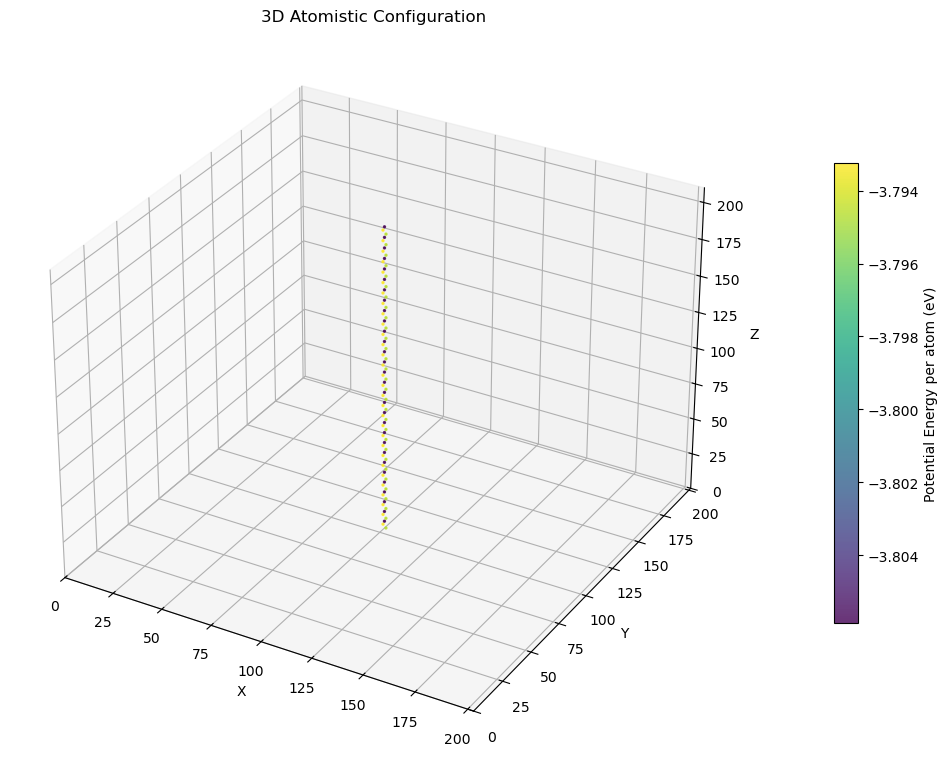

In [29]:
plot_atomistic_data_3d(dislocation_df, box)

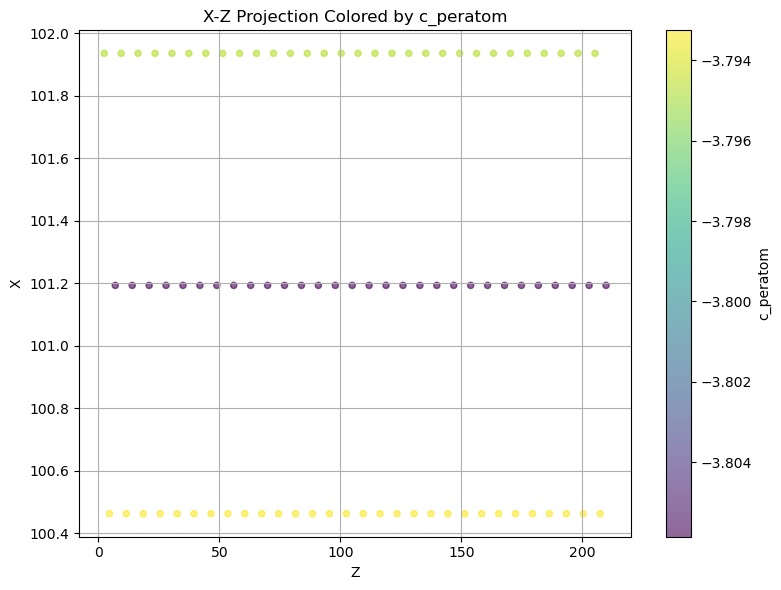

In [30]:
def plot_xz_colored_by_cperatom(atom_df, cmap='viridis', s=20, alpha=0.6):
    """
    Plots a 2D scatter plot with Z on X-axis and X on Y-axis, colored by c_peratom.

    Parameters:
        atom_df (pd.DataFrame): Must contain 'x', 'z', and 'c_peratom' columns.
        cmap (str): Colormap for c_peratom.
        s (float): Size of scatter points.
        alpha (float): Transparency of points.
    """
    if not all(col in atom_df.columns for col in ['x', 'z', 'c_peratom']):
        raise ValueError("atom_df must contain 'x', 'z', and 'c_peratom' columns")

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(atom_df['z'], atom_df['x'], c=atom_df['c_peratom'], cmap=cmap, s=s, alpha=alpha)

    plt.xlabel('Z')
    plt.ylabel('X')
    plt.title('X-Z Projection Colored by c_peratom')
    cbar = plt.colorbar(sc)
    cbar.set_label('c_peratom')

    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_xz_colored_by_cperatom(dislocation_df)

In [ ]:
def get_high_energy_atom_ids(atom_df, box, threshold):
    if not all(col in atom_df.columns for col in ['id', 'z', 'c_peratom']):
        raise ValueError("atom_df must contain 'id', 'z', and 'c_peratom' columns")

    z_center = (box['zlo'] + box['zhi']) / 2

    # Filter for high-energy atoms
    dis_core_atoms = atom_df[atom_df['c_peratom'] > threshold].copy()

    # Calculate distance from center in Z
    dis_core_atoms['z_dist'] = (dis_core_atoms['z'] - z_center).abs()

    # Sort by distance to Z center
    sorted_atoms = dis_core_atoms.sort_values(by='z_dist')

    # Extract sorted IDs
    sorted_ids = sorted_atoms['id'].tolist()

    # Save to file
    filepath = 'deleted_ids.txt'
    with open(filepath, 'w') as f:
        for aid in sorted_ids:
            f.write(f"{aid}\n")

    return sorted_ids

deleted_ids = get_high_energy_atom_ids(dislocation_df, box, -3.82)